# __Puffins__
# Modelling a strictly periodic time series signal
## NB 01 - An introduction

This notebook takes us through the application of the puffins model for strictly periodic signals in time series data as applied to astronomical time series of eclipsing binary stars. Specifically, this notebook is intended to demonstrate how __puffins__ can be used modularly or through classes.

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

from pythia.timeseries.lombscargle import LS_periodogram
from puffins.utils import construct_design_matrix
from puffins.basis_functions import basis_constant, basis_linear, basis_polynomial
from puffins.solver import solve
from puffins.weight_functions import matern32

np.random.seed(42) # to enforce reproducibility
RCOND = 1e-14 # numerical rounding for matrix conditioning
plotnum=1

## U Gru

The specific use case is that of U Gru, an eclipsing binary with a pulsating A-type primary star and a low mass, bloated, post mass transfer K-type giant for the secondary in a 1.855 d orbit ( [Bowman et al., 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...883L..26B/abstract); [Johnston et al., 2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...670A.167J/abstract) ). In the original case, the eclipse signal couldn't be uniquely modelled with PHOEBE because we didn't have enough data (specifically, we were missing spectra of the secondary, so we couldn't find a unique mass ratio). Furthermore, there is an apparent time-dependent deviation from the raw binary model that is likely caused by circum stellar/binary material that is adding a non-negligible amount of light to the system. 

Even in the follow up paper, due to the improper model and lack of data, we were unable to get a full binary solution for publishing and had to remove the binary signal with a spline interpolation - which leaves much to be desired (Johnston et al., 2023). To further complicate things, the spline interpolation required us to bin the data non-uniformly, with special attention to times of sharp variation. This workflow is hard to generalize because each binary is different, and so we wanted to come up with a simple, fast, and flexible model to efficiently remove the binary signal from a lightcurve to then investigate the residuals. 

Now, let's get started and download / unpack the data

In [2]:
# Un-comment this if you want to use lightkurve to get your data
# import lightkurve as lk
# search = lk.search_lightcurve('U Gru', cadence=120)
# lc = search[-1].download().remove_nans().remove_outliers().normalize()
# time = lc.time.value
# flux = lc.flux.value

# Otherwise, this is much quicker
time, flux = np.loadtxt('../data/ugru.dat').T
npoints = len(time)
print(f'Time series contains {npoints} data points')

Time series contains 15000 data points


Let's take a look at the raw data

Text(0, 0.5, 'Normalized Flux')

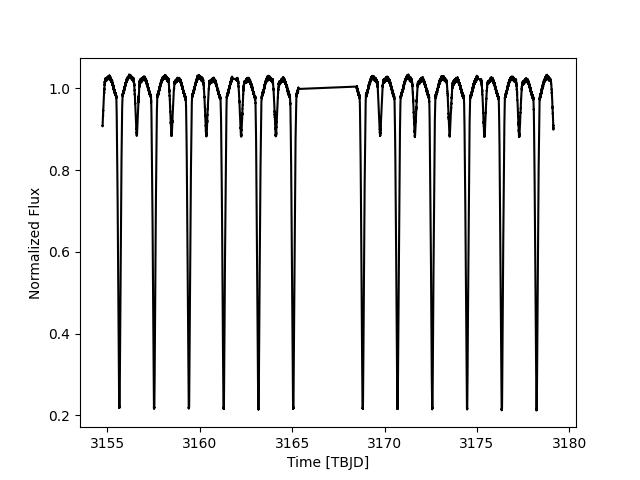

In [3]:
fig_lc, ax_lc = plt.subplots(num=plotnum)
plotnum += 1
ax_lc.plot(time, flux, 'k-')
ax_lc.set_xlabel('Time [TBJD]')
ax_lc.set_ylabel('Normalized Flux')

As we can see, the main signal is a purely periodic one consisting of repeated and alternating downward excursions (eclipses).

As we might imagine, this will have a very predictable signature in the periodogram. So, let's take a look at the periodogram below!

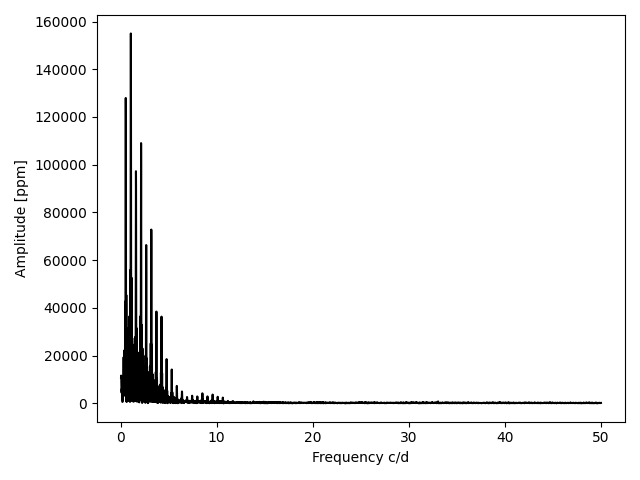

In [4]:
nu, amp = LS_periodogram(time, flux-np.median(flux), max=50)
fig, ax = plt.subplots(num=plotnum)
plotnum += 1
ax.plot(nu, amp*1e6, 'k-')
ax.set_xlabel('Frequency c/d')
ax.set_ylabel('Amplitude [ppm]')
fig.tight_layout()
plt.savefig('ugru_periodogram.png')

## Harmonic forest

As we might have expected, all we see is a series of harmonics at integer multiples of the binary orbital frequency - this is a result of the highly non-sinusoidal nature of the eclipse signal. The problem is, we are looking for the signal that is _below_ (lower amplitude than) the harmonics.

Now, in our papers, we used two different methods to remove the binary signal. In the first paper, we iteratively removed harmonics of the binary frequency one at a time. In the second paper, we designed a custom routine that binned the data unevenly and then fit a spline interpolation through the bins to give an _effective_ model of the binary signal to remove. 

In both cases, the procedure was fairly time consuming and difficult to replicate in a quick and automated fashion. 

## Puffins

The point of __puffins__ is to generalize this workflow.

In practice, we will use a linear model (think y=mx+b, but slightly more complicated) to model the binary signal quickly and efficiently. What does this look like? 

Our model is of the form $\mathbf{Y} = \mathbf{W}^{1/2} \mathbf{X} \beta$, where __Y__ (n x 1) are our target data (the flux observations), __X__ is the (n x p) design matrix with the time stamps of our observations, __W__ (n x n) is the diagonal weight matrix, and __&beta;__ is the (p x 1) coefficient matrix.

### Feature embedding

Since we know that the eclipsing binary signal is __strictly periodic__ over the time span of the data set, we can make use of a feature embedding such that we embed the time stamps $t_i$ of our observations into a larger dimensional __Fourier basis__ consisting of the __K__ harmonics of the binary orbital frequency $f_{orb}$. Thus, instead of our design matrix looking like:

$\begin{pmatrix}
 1 & t_0 \\
 1 & t_1\\
 1 & ... \\
 1 & t_{N-1}
 \end{pmatrix}$

 It will have $p=2K+1$ columns (features) as we expand each time point $t_i$ around each $k_j; j=1...K$ harmonic as $\cos\left(k_j 2\pi f_{orb} t_i\right)\,\,\sin\left( k_j 2\pi f_{orb} t_i\right)$. Thus, our design matrix has the form:


 $\begin{pmatrix}
 1 & \cos\left(1\cdot 2\pi f_{orb} t_0\right) & \sin\left(1\cdot 2\pi f_{orb} t_0\right) & \cos\left(2 \cdot 2\pi 2 f_{orb} t_0\right) & \sin\left(2 \cdot 2\pi f_{orb} t_0\right) & ... & \cos\left(K \cdot 2\pi f_{orb} t_0 \right) & \sin\left(K \cdot 2\pi f_{orb} t_0\right) \\
 1 & \cos\left(1\cdot 2\pi f_{orb} t_1\right) & \sin\left(1\cdot 2\pi f_{orb} t_1\right) & \cos\left(2 \cdot 2\pi 2 f_{orb} t_1\right) & \sin\left(2 \cdot 2\pi f_{orb} t_1\right) & ... & \cos\left(K \cdot 2\pi f_{orb} t_1 \right) & \sin\left(K \cdot 2\pi f_{orb} t_1\right) \\
 1 & \cos\left(1\cdot 2\pi f_{orb} t_2\right) & \sin\left(1\cdot 2\pi f_{orb} t_2\right) & \cos\left(2 \cdot 2\pi 2 f_{orb} t_2\right) & \sin\left(2 \cdot 2\pi f_{orb} t_2\right) & ... & \cos\left(K \cdot 2\pi f_{orb} t_2 \right) & \sin\left(K \cdot 2\pi f_{orb} t_2\right) \\
 1 & ... & ... & ... & ... & ... & ... & ... \\
 1 & \cos\left(1\cdot 2\pi f_{orb} t_{N-1}\right) & \sin\left(1\cdot 2\pi f_{orb} t_{N-1} \right) & \cos\left(2 \cdot 2\pi 2 f_{orb} t_{N-1}\right) & \sin\left(2 \cdot 2\pi f_{orb} t_{N-1}\right) & ... & \cos\left(K \cdot 2\pi f_{orb} t_{N-1} \right) & \sin\left(K \cdot 2\pi f_{orb} t_{N-1}\right) \\
 \end{pmatrix}$



 ### Weighted Least Squares (WLS) Solution
 In order to provide the best fit to the data __Y__ given the features __X__, we can use the weighted-Least-Square (WLS) of the form:
 $\hat\beta_{WLS} = \left( X^T W X  \right)^{-1} X^T W Y$ 

 Where $\hat\beta$ is the feature coefficient vector that minimizes the norm of the residuals between our model and the data. 

 ### Ridge Regression (RR) Solution
 In practice the value of __K__ may be arbitrarily high, and thus the WLS solution may have ill-behaved feature coefficients. As such, we may want to penalize the coefficients if they get larger than is necessary to sufficiently predict the data. In this case, we can apply a _Ridge Regression_, whereby we add a common penalty to all terms in the form of the matrix $\lambda \mathbf{I}$, where $\mathbf{I}$ is the (p x p) identity matrix. 

 In this case, our Ridge regression solution is of the form:
 $\hat\beta_{RR} = \left( X^T W X  + \lambda \mathbf{I} \right)^{-1} X^T W Y$ 

### Feature Weighting (FW) Solution
More generally, we can consider the case where we have a __feature weighting__ in the (p x p) matrix $\Lambda$ that more cleverly penalizes the feature coefficients in $\beta$, say, according to the harmonic order K. Since we are working in a Fourier basis, it makes sense to use a feature weighting that preferentially penalizes higher order harmonic terms as $k_j \rightarrow K$

In this case, our Feature Weighted regression solution is: 
 $\hat\beta_{FW} = \left( X^T W X  + \Lambda \right)^{-1} X^T W Y$, 

Here, the diagonal components of $\Lambda$ are given by $\left[ \Lambda^{-1} \right]_{jj} = \left(\frac{1}{1 + \omega_j^2 \alpha^2}\right)^2$, where $\alpha$ is a parameter that controls the effective width of our feature, and $\omega_j$ is the (angular) frequency at the $k_j$-th harmonic: $\omega_j = k_j \cdot 2 \pi f_j $. Thus, we see that the weight of the feature decreases as the harmonic and therefore frequency increases.


### Over-determined vs. under-determined cases

This framework allows for an arbitrarily large number of harmonics K to be used in the feature embedding. Depending on the data being used, this could result in the situation where you have either more data points N than features $p=2K+1$, ($N > p$) where the fit is over-determined, or the case where you have more features than data points, ($N < p$) where the fit is underdetermined. 

In the case of our feature weighted regression, this leads to two different formulations of the solution:
 - $\left(N > p\right)~\rightarrow~\hat\beta_{FW} = \left( X^T W X  + \Lambda \right)^{-1} X^T W Y$ 
 - $\left(N < p\right)~\rightarrow~\hat\beta_{FW} = \Lambda^{-1}X^T\left( X \Lambda^{-1} X^T  + W \right)^{-1} Y$ 

Depending on the specific dataset and number of harmonics that you've included, __puffins__ will choose which formulation to use in the background.


For a more detailed discussion, we refer the reader to: [Hogg & Villar, 2021](https://arxiv.org/abs/2101.07256). 

 

## Results

We're just about ready to go - we just need to provide an estimate of the base frequency of the signal that we are modelling. In this case, we know the orbital period really well, and so the frequency is just the inverse of this.

We also need to determine an arbitrary number of harmonics to use. For this example, we'll use $K=500$, resulting in $p=1001$ features.
For this example, that firmly places us in the over-determined case where (N=15000 >> p=1001).

In [5]:
period = 1.88045
K = 500

We only need to construct the design matrix and calculate the $\omega$'s associated with each datapoint-harmonic pair once, so we'll do that here.

In [6]:
X, omegas= construct_design_matrix(time, basis_functions=[basis_constant,], feature_embedding='fourier', period=period, n_harmonics=K)

Now the time has come for us to calculate our model! For the sake of this example, we'll not worry about the uncertainties on the data.

In [7]:
betas_fw = solve(X, flux, method='fw', L=1./matern32(omegas, 0.1/period)**2, W=None)

In [8]:
# Reconstruct the predicted flux based on our linear models
predicted_fw = X @ betas_fw

# Calculate the residuals
resid_fw = flux - predicted_fw

Since we have our model, let's take a look at how well it fits the data. First, we'll look at the full time series.

Text(0, 0.5, '(Predicted) Flux')

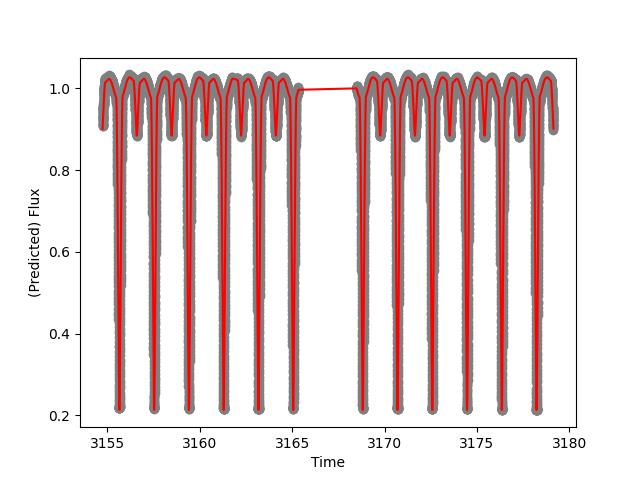

In [9]:
plotnum += 1
fig_, ax_ = plt.subplots(num=plotnum)
ax_.plot(time, flux, 'o', color='grey', alpha=0.95)
ax_.plot(time, predicted_fw, 'r-')
ax_.set_xlabel('Time')
ax_.set_ylabel('(Predicted) Flux')

Aha! The model seems to be doing __very__ well. Since this is a _periodic_ signal we're dealing with, we can phase fold the data and get another look at it.

Text(0, 0.5, '(Predicted) Flux')

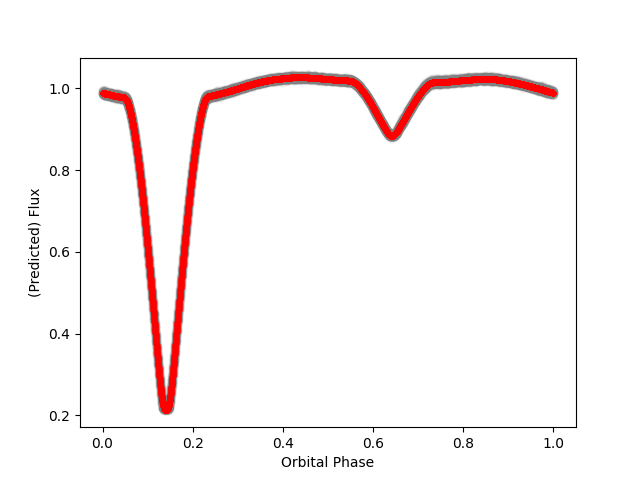

In [10]:
plotnum += 1
fig_, ax_ = plt.subplots(num=plotnum)
ph = (time/period)%1
ax_.plot(ph, flux, 'o', color='grey', alpha=0.05)
ax_.plot(ph, predicted_fw, 'r.')
ax_.set_xlabel('Orbital Phase')
ax_.set_ylabel('(Predicted) Flux')

Again, we can see that the model does __remarkably__ well.

In case you forgot why we were doing this, we can now get back to the other signals that are hiding in the residuals after subtracting out the periodic signal model.

In [11]:
# Now we want to calculate a periodogram of the residuals and see
# if we can identify any new features (i.e., pulsations) that 
# were previously hiding under the harmonic forest from the binary

nu_fw, amp_fw = LS_periodogram(time, resid_fw-np.median(resid_fw), max=50)


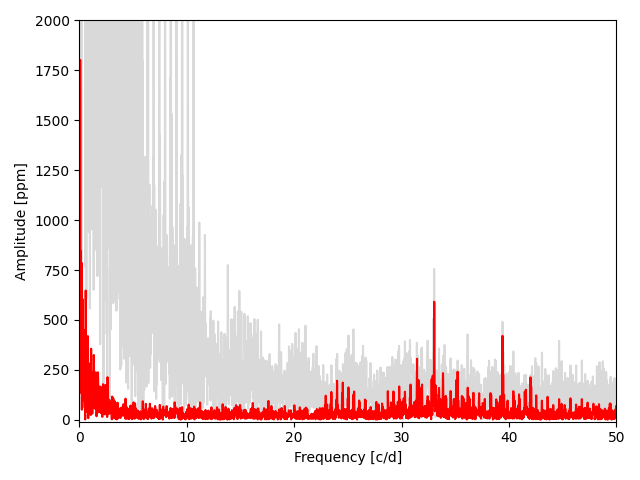

In [12]:
plotnum+=1
fig_, ax_ = plt.subplots(num=plotnum)
ax_.plot(nu, amp*1e6, 'k', alpha=0.15)
ax_.plot(nu_fw, amp_fw*1e6, 'r')
ax_.set_xlabel('Frequency [c/d]')
ax_.set_ylabel('Amplitude [ppm]')
ax_.set_ylim(-10,2000)
ax_.set_xlim(0,50)
fig_.tight_layout()
plt.savefig('ugru_residual_periodogram.png')


This is the signal that we were actually looking for! 
The periodogram of the residuals in red displays a much lower amplitude signal that was effectively hidden by the larger amplitude signal, which we never would have noticed in the original periodogram (grey).

## The TimeSeries and Model classes

In the cells above, we just used __puffins__ as a collection of modular functions, which, as we can see, works a treat. However, we also provide functionality to treat the time series and model as class objects for convenience and scalability. 

In [13]:
from puffins.data import TimeSeries,LinearModel

data = TimeSeries(time, flux)
print(data)

TimeSeries with properties:
Time base of dataset: 24.3899784208229
Median time-step of data set: 0.001388874274198315
Number of data points: 15000
Number of models computed: 0


In [15]:
fwls = LinearModel(basis_functions=[basis_constant,], feature_embedding='fourier', 
                   feature_weighting_function=matern32, feature_weighting_width=0.01,
                   method='fw', period=period, n_harmonics=100, W=None)
fwls.set_X_train(data.predictors)
fwls.train(data.targets)
print(fwls)

Linear Model with properties: 
 Basis functions: ['def basis_constant(\n                    x: np.ndarray\n                   ) -> np.ndarray:\n    """\n    Constant basis function.\n    Returns an array of ones with the same shape as x.\n\n    Parameters:\n    - x: np.ndarray\n        Array of input values\n\n    Returns:\n    - np.ndarray\n        Array of ones with the same shape as x\n    """\n\n    return np.ones_like(x)\n']
Feature embedding: 7
Regression method: fw
Regression kwargs: {'W': None, 'L': array([  1.        ,   1.00223413,   1.00223413,   1.00895148,
         1.00895148,   1.02019692,   1.02019692,   1.03604523,
         1.03604523,   1.05660113,   1.05660113,   1.08199921,
         1.08199921,   1.11240402,   1.11240402,   1.14801   ,
         1.14801   ,   1.18904151,   1.18904151,   1.23575282,
         1.23575282,   1.28842813,   1.28842813,   1.34738152,
         1.34738152,   1.41295704,   1.41295704,   1.4855286 ,
         1.4855286 ,   1.56550005,   1.5655000

For convenience, we added the functionality to add the model to the original time series class. This way you can keep track of all of the models made for the given time series.

In [16]:
data.add_model(fwls)
print(data)

TimeSeries with properties:
Time base of dataset: 24.3899784208229
Median time-step of data set: 0.001388874274198315
Number of data points: 15000
Number of models computed: 1


We can also use the model to predict what the data would look like in gaps, the past, or in the future!

Text(0, 0.5, '(Predicted) Flux')

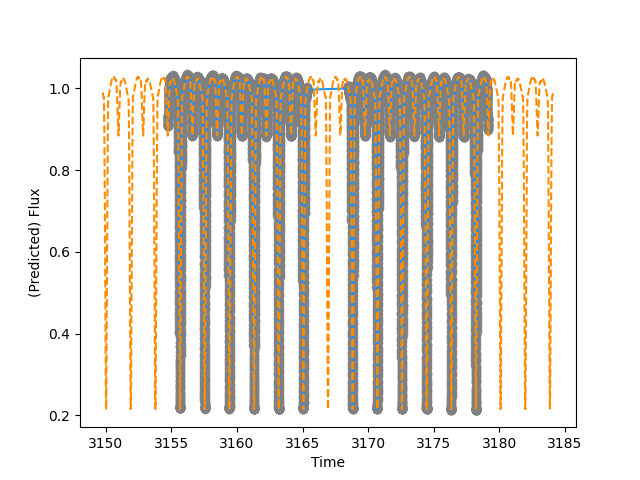

In [17]:
xnew = np.linspace(data.predictors.min()-5, data.predictors.max()+5, 10000)
plotnum += 1
fig_, ax_ = plt.subplots(num=plotnum)
ax_.plot(time, flux, 'o', color='grey', alpha=0.85)
ax_.plot(time, fwls.trained_model, '-', color='dodgerblue')
ax_.plot(xnew, fwls.predict(xnew)[1], '--', color='darkorange')
ax_.set_xlabel('Time')
ax_.set_ylabel('(Predicted) Flux')

## How to interpret the regression coefficients

The embedding effectively means that we're expanding our features around the K harmonics of the base frequency with equal numbers of cosine and sine terms.


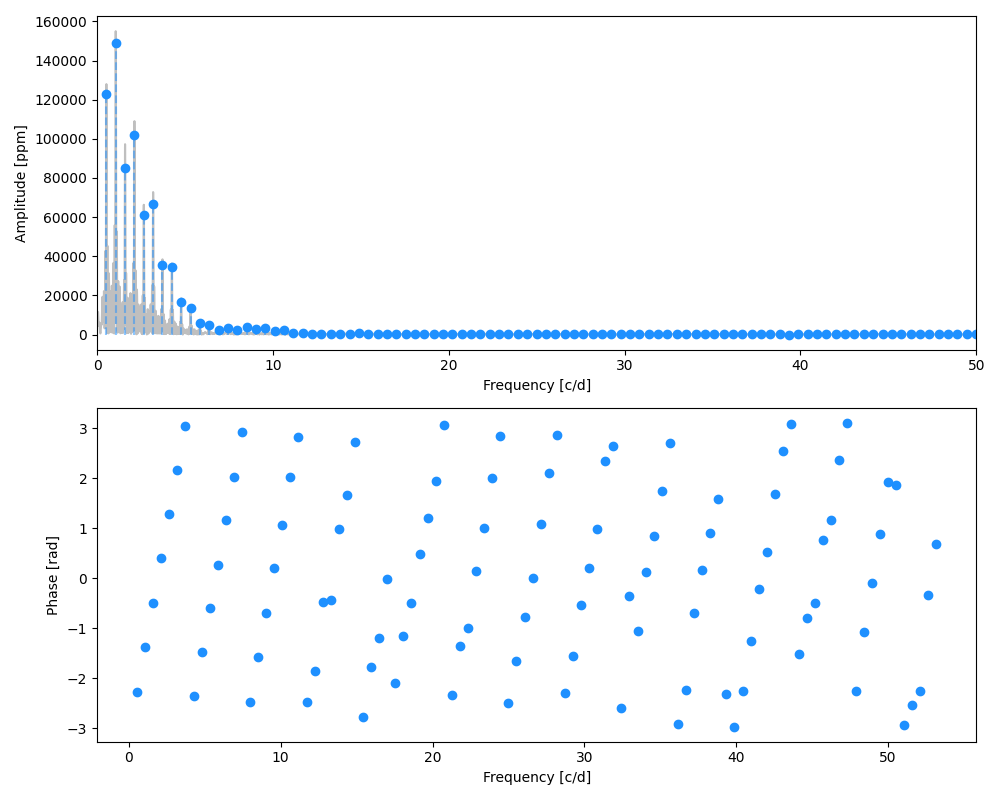

In [18]:
cosines = fwls.coefficients[1::2]
sines = fwls.coefficients[2::2]

harmonics =  np.arange(1,101) / period
ampliudes = np.sqrt(cosines**2 + sines**2)
phases = np.arctan2(sines, cosines)

plotnum += 1
fig_, axes_ = plt.subplots(2, 1, figsize=(10,8),num=plotnum)
axes_[0].plot(nu, amp*1e6, 'k', alpha=0.25)
axes_[0].plot(harmonics, ampliudes*1e6, 'o', color='dodgerblue')
for harmonic, ampliude in zip(harmonics, ampliudes):
    axes_[0].plot([harmonic, harmonic], [0, ampliude*1e6], 'dodgerblue', linestyle='--', alpha=0.5)
# axes_[0].axvline(harmonics, ymin=np.zeros(100), ymax=ampliudes*1e6, color='dodgerblue', linestyle='--', alpha=0.5)
axes_[0].set_xlabel('Frequency [c/d]')
axes_[0].set_ylabel('Amplitude [ppm]')
axes_[0].set_xlim(0,50)
axes_[1].plot(harmonics, phases, 'o', color='dodgerblue')
axes_[1].set_xlabel('Frequency [c/d]')
axes_[1].set_ylabel('Phase [rad]')

fig_.tight_layout()
plt.show()